We'll first try with the simplest possible approach based on char-RNN that read all the excerpt and predicts in output the target complexity.

In [1]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import string
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

# seed everything
seed = 1
random.seed(seed)
os.environ['PYTHONASSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

cuda is used


In [2]:
# Read the data
training = pd.read_csv('internal_train.csv').to_numpy()
test = pd.read_csv('internal_test.csv').to_numpy()
blind_test = pd.read_csv('test.csv').to_numpy()
print(training.shape, test.shape, blind_test.shape)

(2434, 6) (400, 6) (7, 4)


In [3]:
# id,url_legal,license,excerpt,target,standard_error

# We have 5 features (id,url_legal,license,excerpt,standard_error) and 1 output 'target'

# For our model we'll only use the excerpt as a feature
training_X = training[:, 3]
training_Y = training[:, 4]
print('training shape =', training_X.shape, training_Y.shape)

test_X = test[:, 3]
test_Y = test[:, 4]
print('test shape =', test_X.shape, test_Y.shape)

blind_test_X = blind_test[:, 3]
print('BLIND test shape =', blind_test_X.shape)

training shape = (2434,) (2434,)
test shape = (400,) (400,)
BLIND test shape = (7,)


In [4]:
print(training_X[0])
print('\nTarget =', training_Y[0])

Long, long ago when the earth was new, great mountains covered the world like a blanket, and tall trees spiked the sky. In this world, there was a deep dark pool, silent and cold. At the bottom of this pool were two snakes. One had thick strongly patterned coils, and the other was smaller and more delicate. Then one day, there was a great storm. A flash of lightning pierced right to the bottom of the pool. The waters parted for a moment. The snakes saw the earth above, full of colors and shapes and feathered creatures. When the waters closed again, the snakes could not forget the beauty they had seen. "We cannot stay in this dark cold pool any longer," they said to each other. "Let us go up and see the earth above." "How will we live on earth?" said the smaller snake. "Will we crawl on our bellies?" "The birds of the air will not laugh at us for being so low," said her friend. "We will not crawl, we will walk!" Very slowly the snakes uncoiled themselves. Close together they began to sw

Min target = -3.676267773 | Max target = 1.711389827


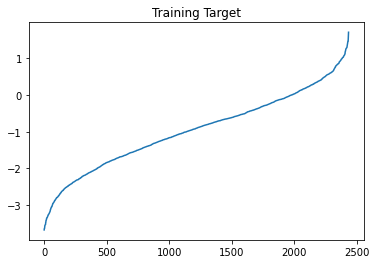

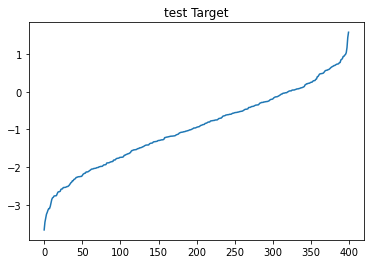

In [5]:
plt.plot(np.sort(training_Y))
plt.title('Training Target')

plt.figure()
plt.plot(np.sort(test_Y))
plt.title('test Target')
print(f'Min target = {np.min(training_Y)} | Max target = {np.max(training_Y)}')

### Turning excerpts into Tensors

To represent a single letter, we use a "one-hot vector" of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

So, if we have an excerpt of length 20 the final tensor will be of size 20 x 1 x 57 (alphabet size)

In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters, dtype=torch.float)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Testing words').size())
print(lineToTensor('Testing words')[0, 0, :])

torch.Size([13, 1, 57])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


In [7]:
# We want the entire dataset encoded with 1-of-k char encoding
# So, the final size will be (n_samples, 1, excerpt_length, 57) (extra dimension 1 inserted for pytorch batch)
# Since a tensor has fixed size we pad the sequences to ensure all have the same length.

# Get the max excerpt length and encode the training set
max_excerpt_len = len(max(training_X, key=len))
enc_training_X = np.zeros((training_X.shape[0], 1, max_excerpt_len, n_letters))
traing_lengths = []
for i, x in enumerate(training_X):
    enc_x = lineToTensor(x)
    enc_training_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1, 57))
    traing_lengths.append(enc_x.shape[0])

print('encoded Training shape =',enc_training_X.shape)


max_excerpt_len = len(max(test_X, key=len))
enc_test_X = np.zeros((test_X.shape[0], 1, max_excerpt_len, n_letters))
test_lengths = []
for i, x in enumerate(test_X):
    enc_x = lineToTensor(x)
    enc_test_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1, 57))
    test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_test_X.shape)


max_excerpt_len = len(max(blind_test_X, key=len))
enc_blind_test_X = np.zeros((blind_test_X.shape[0], 1, max_excerpt_len, n_letters))
blind_test_lengths = []
for i, x in enumerate(blind_test_X):
    enc_x = lineToTensor(x)
    enc_blind_test_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1, 57))
    blind_test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_blind_test_X.shape)

encoded Training shape = (2434, 1, 1341, 57)
enc. Test shape = (400, 1, 1323, 57)
enc. Test shape = (7, 1, 1144, 57)


In [8]:
from math import floor
#Utility function to get a random sample
def randomTrainingExample():
    i = np.random.randint(0, training_X.shape[0])
    excerpt_tensor = lineToTensor(training_X[i])
    target_tensor = torch.tensor(training_Y[i], dtype=torch.float)
    return excerpt_tensor.to(device), target_tensor.to(device)

randomTrainingExample()

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
 tensor(-1.4338, device='cuda:0'))

In [9]:
class CommonLitDataset(Dataset):
    # X: numpy matrix (n_samples, 1, excerpt_length, n_letters)
    # basically is a matrix where each row is a string..  
    def __init__(self, X, Y, lenghts):
        self.X = X
        self.Y = Y
        self.lengths = lenghts

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (torch.tensor(self.X[idx][0]).float(), self.lengths[idx]), torch.tensor(self.Y[idx]).float()

In [10]:
# Define the model

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.output_layer1 = nn.Linear(hidden_size, hidden_layer_size)
        self.tanh = nn.Tanh()
        self.output_layer2 = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.output_layer1(hidden)
        output = self.tanh(output)
        output = self.output_layer2(output)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

# Model parameters
n_hidden = 256
n_output = 1 # Just the target complexity
hidden_layer_size = 128

rnn = RNN(n_letters, n_hidden, n_output).to(device)

In [11]:
# Test the rnn
input = lineToTensor('Random test').to(device)
hidden = rnn.initHidden(batch_size=1)

print(input[0].shape)

output, next_hidden = rnn(torch.unsqueeze(input[0], dim=1), hidden)
print(output.item())

torch.Size([1, 57])
0.07795041054487228


In [12]:
# Define a single step of training where it looks at a single excerpts and apply GD
criterion = nn.MSELoss(reduction='sum')

def train(target_tensor, excerpt_tensor, batch_size, lenghts_sequences):
    hidden = rnn.initHidden(batch_size)

    rnn.zero_grad()

    packed_excerpt_tensor = torch.nn.utils.rnn.pack_padded_sequence(excerpt_tensor, lenghts_sequences, batch_first=True, enforce_sorted=False)

    output, hidden = rnn(packed_excerpt_tensor, hidden)

    target_tensor = torch.reshape(target_tensor, (1, batch_size, 1))

    loss = criterion(output, target_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 1}

commonlit_dataset = CommonLitDataset(enc_training_X, training_Y, traing_lengths)
training_generator = torch.utils.data.DataLoader(commonlit_dataset, **params)

In [ ]:
import time
import math

n_iters = 50
print_every = 1
plot_every = 1

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

learning_rate = 0.0005

for iter in range(1, n_iters + 1):
    for excerpts_batch, targets_batch in training_generator:
        excerpts_batch, excerpts_lenghts = excerpts_batch[0], excerpts_batch[1]
        excerpts_batch, targets_batch = excerpts_batch.to(device), targets_batch.to(device)

        output, loss = train(targets_batch, excerpts_batch, excerpts_batch.shape[0], excerpts_lenghts)
        current_loss += loss

    # Avg MSE
    current_loss /= enc_training_X.shape[0]

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) Loss = %.4f' % (iter, iter / n_iters * 100, timeSince(start), current_loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses)

## Evaluate the model

In [ ]:
test_params = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 1}

internal_test_dataset = CommonLitDataset(enc_test_X, test_Y, test_lengths)
test_generator = torch.utils.data.DataLoader(internal_test_dataset, **test_params)


blind_test_params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 1}

blind_test_dataset = CommonLitDataset(enc_blind_test_X, np.zeros(enc_blind_test_X.shape), blind_test_lengths)
blind_test_generator = torch.utils.data.DataLoader(blind_test_dataset, **blind_test_params)

In [ ]:
# Compute the final MSE on the training set
def compute_squared_error(generator):
    error = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        mse = 0.0
        for excerpts_batch, targets_batch in generator:
            excerpts_batch, excerpts_lenghts = excerpts_batch[0], excerpts_batch[1]
            excerpts_batch, targets_batch = excerpts_batch.to(device), targets_batch.to(device)

            batch_size = excerpts_batch.shape[0]

            hidden = rnn.initHidden(batch_size)

            rnn.zero_grad()

            packed_excerpt_tensor = torch.nn.utils.rnn.pack_padded_sequence(excerpts_batch, excerpts_lenghts, batch_first=True, enforce_sorted=False)

            output, hidden = rnn(packed_excerpt_tensor, hidden)

            targets_batch = torch.reshape(targets_batch, (1, batch_size, 1))

            loss = criterion(output, targets_batch)
            mse += loss.item()
    return mse
print('Training RMSE =', np.sqrt(compute_squared_error(training_generator) / enc_training_X.shape[0]))
print('Internal TEST RMSE =', np.sqrt(compute_squared_error(test_generator) / enc_test_X.shape[0]))
    

# Compute blind test set outputs

In [ ]:
outputs = []
with torch.no_grad():
    mse = 0.0
    for i, (excerpts_batch, targets_batch) in enumerate(blind_test_generator):
        excerpts_batch, excerpts_lenghts = excerpts_batch[0], excerpts_batch[1]

        excerpts_batch = excerpts_batch.to(device)

        batch_size = excerpts_batch.shape[0]

        hidden = rnn.initHidden(batch_size)

        rnn.zero_grad()

        packed_excerpt_tensor = torch.nn.utils.rnn.pack_padded_sequence(excerpts_batch, excerpts_lenghts, batch_first=True, enforce_sorted=False)

        output, hidden = rnn(packed_excerpt_tensor, hidden)
        id = blind_test[i, 0]
        print(id, output.item())
        outputs.append((id, output.item()))

# Save outputs to submission.csv
if False:
    with open('submission.csv', 'w') as f:
        f.write('id,target\n')
        for id, o in outputs:
            f.write(id+','+o+'\n')

 NEXT:

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 
 
 
    Try the nn.LSTM and nn.GRU layers
    Combine multiple of these RNNs as a higher level network
